In [12]:
from google.colab import files
uploaded = files.upload()

Saving train_MaefO4x.zip to train_MaefO4x.zip


In [13]:
! unzip train_MaefO4x.zip
! unzip test_MElQnvy.zip

Archive:  train_MaefO4x.zip
  inflating: jokes.csv               
  inflating: train.csv               
Archive:  test_MElQnvy.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

In [15]:
train=pd.read_csv('train.csv')
jokes=pd.read_csv('jokes.csv')
test=pd.read_csv('test.csv')

In [16]:
print(train.shape,jokes.shape,test.shape)

(1092059, 4) (139, 2) (537880, 3)


In [17]:
sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (15,10) 

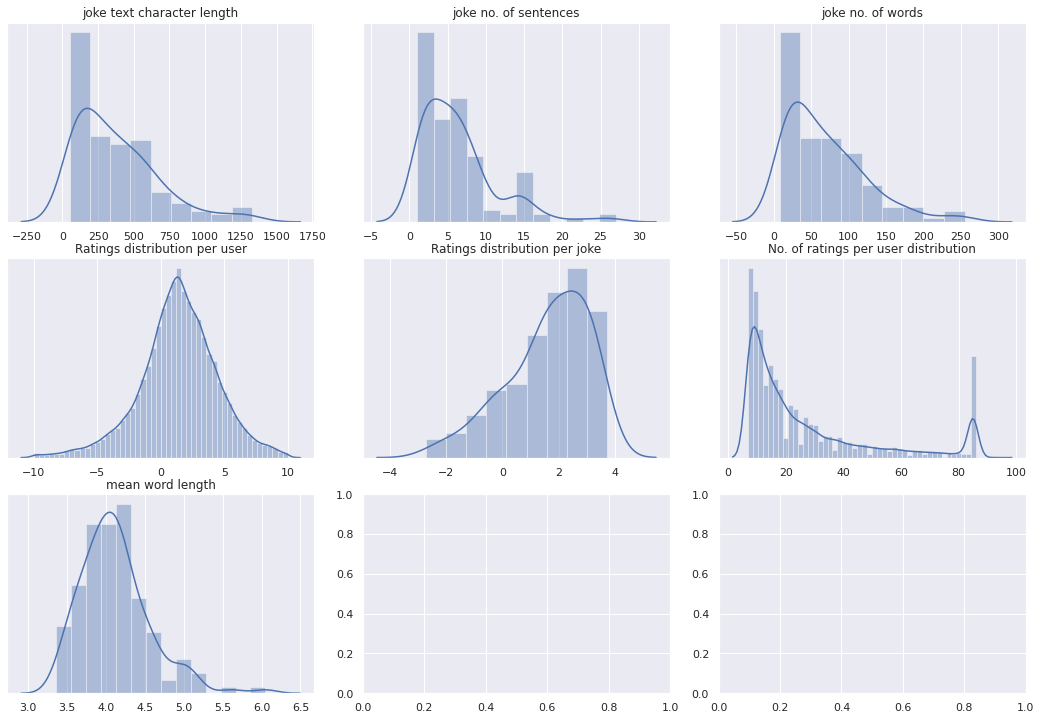

In [18]:
# Features

fig,ax=plt.subplots(3,3)
fig.tight_layout()

jokes['char_len']=jokes.joke_text.apply(len)
sns.distplot(jokes['char_len'],ax=ax[0,0])
ax[0,0].set_title('joke text character length')
ax[0,0].set_xlabel('')
ax[0,0].yaxis.set_visible(False)

jokes['n_sentences']=jokes.joke_text.apply(lambda x: len(re.findall(r'\.',x))+1)
sns.distplot(jokes['n_sentences'],ax=ax[0,1])
ax[0,1].set_title('joke no. of sentences')
ax[0,1].set_xlabel('')
ax[0,1].yaxis.set_visible(False)

jokes['n_words']=jokes.joke_text.apply(lambda x: len(re.findall(r' ',x))+1)
sns.distplot(jokes['n_words'],ax=ax[0,2])
ax[0,2].set_title('joke no. of words')
ax[0,2].set_xlabel('')
ax[0,2].yaxis.set_visible(False)

sns.distplot(train.groupby('user_id').mean()['Rating'],ax=ax[1,0])
ax[1,0].set_title('Ratings distribution per user')
ax[1,0].set_xlabel('')
ax[1,0].yaxis.set_visible(False)
sns.distplot(train.groupby('joke_id').mean()['Rating'],ax=ax[1,1])
ax[1,1].set_title('Ratings distribution per joke')
ax[1,1].set_xlabel('')
ax[1,1].yaxis.set_visible(False)
sns.distplot(train.groupby('user_id').count(),ax=ax[1,2])
ax[1,2].set_title('No. of ratings per user distribution')
ax[1,2].set_xlabel('')
ax[1,2].yaxis.set_visible(False)

jokes['mean_word_len']=jokes.joke_text.apply(lambda x: np.mean([len(w) for w in re.findall(r'\w+',x)]))
sns.distplot(jokes['mean_word_len'],ax=ax[2,0])
ax[2,0].set_title('mean word length')
ax[2,0].set_xlabel('')
ax[2,0].yaxis.set_visible(False)
plt.show()  

Finding BERT embeddings for each joke

In [19]:
!pip install transformers

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

     |████████████████████████████████| 675kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 29.8MB/s 
     |████████████████████████████████| 3.8MB 44.4MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5da514a6938345a797a2e1e538f87ef0f51b12c6a9be56ef651f44272d061926
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [20]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

joke_examples = jokes['joke_text']

# Randomly choose some examples.
for i in range(10):
    j = random.choice(joke_examples.index)
    
    print('')
    print(wrapper.fill(joke_examples[j]))
    print('')


A neutron walks into a bar and orders a drink. "How much do I owe you?" the
neutron asks. The bartender replies, "For you, no charge."


Hillary, Bill Clinton and the Pope are sitting together on an airplane. Bill
says, "I could throw one thousand-dollar bill out of this plane and make one
person very happy." Hillary says, "I could throw 10 hundred-dollar bills out of
the plane and make 10 people very happy." The Pope chips in and says, "I could
throw Bill out of the airplane and make the whole country happy."


A Panda walks into a bar, sits down at a table and orders a beer and a double
cheeseburger. After he is finished eating, he pulls out a gun and rips the place
with gunfire. Patrons scatter and dive under chairs and tables as the bear runs
out the door. After ensuring that no one is hurt, the bartender races out the
door, and calls after the bear: "What the hell did you do that for?" The bear
calls back, "I'm a Panda. Look it up in the dictionary." The bartender returns,
pulls 

Extracting BERT sentence embeddings for joke text (Approach1: From binary classification model)

In [83]:
from transformers import BertForSequenceClassification,BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Copy the model to the GPU.
model.to(device)

import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 256

    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result 
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.

        logits, encoded_layers = model(
                                      input_ids = input_ids, 
                                      token_type_ids = None, 
                                      attention_mask = attn_mask)  
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)

 # Get the text from one of the comments.
input_text = jokes.iloc[10].joke_text

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ", 
                               width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(jokes)

print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe...
for index, row in jokes.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.joke_text)

    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1

import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

import os
output_dir = './model_save/'
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.

print("Saving embeddings to: ./model_save/embeddings_app1.npy")
np.save('./model_save/embeddings_app1.npy', vecs)


Loading BERT tokenizer...
Getting embedding for sentence:

     What's the difference between a used tire and 365 used condoms? One's a
    Goodyear, the other's a great year.

Done. Embedding shape: (768,)
Generating sentence embeddings for all 139 comments...
Saving embeddings to: ./model_save/embeddings_app1.npy


Extracting BERT sentence embeddings for joke text (Approach2: By averaging intermediate word embeddings)

In [21]:
from transformers import BertModel,BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
model.to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def text_to_embedding(tokenizer, model, in_text):
    ids = tokenizer.encode_plus(
                      in_text,                    # Sentence to encode.
                      add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                  )    

    input_ids=ids['input_ids']
    segment_ids=ids['token_type_ids']
    tokens_tensor = torch.tensor([input_ids]).to(device)
    segments_tensors = torch.tensor([segment_ids]).to(device)

    model.eval()
    with torch.no_grad():
        outputs= model(tokens_tensor, segments_tensors)
        encoded_layers = outputs[2]
    token_vecs = encoded_layers[11][0] # Second last layer encoding of all words

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    return(sentence_embedding)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(jokes)

print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe...
for index, row in jokes.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.joke_text)

    # Store the embeddings.
    embeddings.append(vec.detach().cpu().numpy()) 

    row_num += 1

import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

import os
output_dir = './model_save/'
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.

print("Saving embeddings to: ./model_save/embeddings_app2.npy")
np.save('./model_save/embeddings_app2.npy', vecs)


Generating sentence embeddings for all 139 comments...
Saving embeddings to: ./model_save/embeddings_app2.npy


In [22]:
embeddings_df= pd.DataFrame(data=vecs,    # values
              columns=['emb_feat_'+str(i) for i in range(vecs.shape[1])])

In [23]:
jokes=pd.concat([jokes,embeddings_df],axis=1)

In [24]:
del embeddings_df

In [25]:
jokes.head()

,joke_id,joke_text,char_len,n_sentences,n_words,mean_word_len,emb_feat_0,emb_feat_1,emb_feat_2,emb_feat_3,emb_feat_4,emb_feat_5,emb_feat_6,emb_feat_7,emb_feat_8,emb_feat_9,emb_feat_10,emb_feat_11,emb_feat_12,emb_feat_13,emb_feat_14,emb_feat_15,emb_feat_16,emb_feat_17,emb_feat_18,emb_feat_19,emb_feat_20,emb_feat_21,emb_feat_22,emb_feat_23,emb_feat_24,emb_feat_25,emb_feat_26,emb_feat_27,emb_feat_28,emb_feat_29,emb_feat_30,emb_feat_31,emb_feat_32,emb_feat_33,...,emb_feat_728,emb_feat_729,emb_feat_730,emb_feat_731,emb_feat_732,emb_feat_733,emb_feat_734,emb_feat_735,emb_feat_736,emb_feat_737,emb_feat_738,emb_feat_739,emb_feat_740,emb_feat_741,emb_feat_742,emb_feat_743,emb_feat_744,emb_feat_745,emb_feat_746,emb_feat_747,emb_feat_748,emb_feat_749,emb_feat_750,emb_feat_751,emb_feat_752,emb_feat_753,emb_feat_754,emb_feat_755,emb_feat_756,emb_feat_757,emb_feat_758,emb_feat_759,emb_feat_760,emb_feat_761,emb_feat_762,emb_feat_763,emb_feat_764,emb_feat_765,emb_feat_766,emb_feat_767
0,1,Q. What's O. J. Simpson's web address? A. Slas...,88,6,14,3.875000,0.296312,-0.265346,0.185837,-0.369149,0.227090,0.049445,0.342155,0.558113,-0.344193,-0.038635,-0.109320,-0.345172,-0.152374,0.301920,-0.016021,0.904308,-0.059399,0.429629,-0.238819,0.243694,0.652591,0.277552,-0.357091,-0.353479,0.379622,0.435096,-0.497275,-0.149642,-0.547151,0.192340,0.567075,-0.192471,0.211789,-0.102142,...,-0.327154,-0.484478,-0.394961,0.565923,-0.004361,-0.255303,0.098671,0.152366,-0.141123,-0.016757,0.036805,0.369351,0.274959,-0.235894,-0.303449,-0.298196,-0.081089,0.184962,0.128233,0.285932,-0.102515,-0.033222,-0.341842,0.417579,-0.021711,0.351380,-0.005270,-0.263026,-0.467652,-0.299043,-0.067829,0.113187,-0.174150,-0.174113,0.049017,0.270638,-0.384850,-0.425608,0.156758,0.162003
1,2,How many feminists does it take to screw in a ...,75,2,15,3.625000,0.471784,0.148163,-0.321543,0.014946,-0.362537,-0.143639,-0.166978,0.543149,-0.020337,0.425022,0.606123,-0.380686,-0.196309,0.215560,-0.520256,0.683328,-0.164942,0.089256,-0.408461,0.074499,0.104310,0.168193,-0.414402,0.322503,0.186401,-0.158718,0.048945,-0.284736,0.246041,0.445948,0.766320,-0.244321,-0.038472,-0.110870,...,-0.412461,-0.705915,-0.559732,0.346242,-0.073757,-0.235339,0.603651,0.271907,0.014742,-0.424812,-0.138502,0.175220,-0.193414,-0.041140,0.012836,-0.506609,0.203646,-0.104583,-0.288437,-0.284967,-0.024245,-0.019179,-0.345080,-0.321662,0.402867,0.347789,-0.129767,-0.187033,0.249608,-0.064951,-0.264186,-0.562101,-0.235037,-0.446500,-0.094217,0.189054,0.066197,-0.170922,0.259797,0.458619
2,3,Q. Did you hear about the dyslexic devil worsh...,81,4,16,3.875000,0.307942,-0.449975,0.057796,-0.097015,0.256074,-0.356346,-0.068342,0.871642,0.277392,0.104002,0.126092,-0.307076,-0.415507,0.042113,0.191385,0.590275,0.160703,0.319875,-0.455219,0.327155,0.253465,0.126531,-0.330561,0.563915,0.194973,0.407431,-0.514662,0.228079,-0.584168,0.216347,0.410084,0.049180,-0.086870,-0.263861,...,-0.397001,-0.390884,-0.170454,0.124311,-0.159146,0.409723,0.378521,0.012648,-0.110512,-0.108465,0.299186,0.151480,-0.095842,-0.165731,-0.233544,-0.376446,0.071556,-0.233518,-0.083494,0.247267,-0.217865,0.102825,-0.158439,0.162737,0.110301,0.334740,0.174267,-0.339629,-0.287811,-0.451507,-0.388222,-0.321571,0.070940,-0.139194,0.404892,-0.032575,-0.258411,0.135304,0.321349,-0.100152
3,4,They asked the Japanese visitor if they have e...,99,3,16,4.937500,-0.163382,-0.077142,0.092578,-0.244788,0.334020,-0.041416,0.005184,0.985106,-0.143473,-0.089031,-0.012929,-0.105764,-0.238964,0.007262,-0.386856,0.183464,0.395189,0.024990,-0.109939,0.037044,0.087820,0.246190,0.188055,-0.205817,-0.258816,0.082669,0.255581,0.271191,-0.793399,-0.134486,-0.220310,0.481633,-0.216454,-0.102666,...,-0.124346,-0.391975,0.057962,0.038307,0.313515,-0.546747,0.558490,-0.048573,-0.152112,0.051268,-0.237495,0.119871,0.492922,-0.633200,-0.178922,0.241284,-0.116414,0.098189,0.139675,-0.403891,0.399756,-0.095926,-0.229076,-0.448751,0.178694,0.093985,0.017571,-0.497129,-0.765825,

J-VAE for dimensionality reduction of jokes text representations

In [35]:
import tensorflow as tf
import os
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from IPython.display import clear_output

batch_size=23
original_dim=768
intermediate_dim1=90
intermediate_dim2=50
intermediate_dim3=70
intermediate_dim4=200

latent_dim=3
nb_epochs=630
epsilon_std=1.0

# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h1=Dense(intermediate_dim1, activation='relu')(x)
h2=Dense(intermediate_dim2, activation='relu')(h1)
h3=Dense(intermediate_dim3, activation='relu')(h2)
h4=Dense(intermediate_dim4, activation='tanh')(h3)

z_mean=Dense(latent_dim)(h4)
z_log_var=Dense(latent_dim)(h4)

# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

# decoder network
h_decoder1=Dense(intermediate_dim1, activation='relu')
h_decoder2=Dense(intermediate_dim2, activation='relu')
h_decoder3=Dense(intermediate_dim3, activation='relu')
h_decoder4=Dense(intermediate_dim4, activation='tanh')

x_bar=Dense(original_dim,activation='linear') # Final prediction layer
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # Sampling for decoder
h_decoded1 = h_decoder1(z)
h_decoded2 = h_decoder2(h_decoded1)
h_decoded3 = h_decoder3(h_decoded2)
h_decoded4 = h_decoder4(h_decoded3)
x_decoded = x_bar(h_decoded4)


vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.mse(x,x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)

def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    print(number_of_batches)
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:]
        y_batch = y[index_batch,:]
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

weightsPath = "./joke_weights1.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)

x_train=np.array(jokes.iloc[:138,6:])
print("number of training examples: ", x_train.shape[0])

number of training examples:  138


In [36]:
#vae.load_weights(weightsPath)
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 138), samples_per_epoch=138, nb_epoch=nb_epochs, callbacks=[checkpointer,reduce_lr])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=138, epochs=630)`
  


Epoch 1/630
6.0
138/138 [==============================] - 1s 6ms/step - loss: 51.9928

Epoch 00001: saving model to ./joke_weights1.hdf5
Epoch 2/630
138/138 [==============================] - 1s 4ms/step - loss: 32.3561

Epoch 00002: saving model to ./joke_weights1.hdf5
Epoch 3/630
138/138 [==============================] - 1s 4ms/step - loss: 31.4664

Epoch 00003: saving model to ./joke_weights1.hdf5
Epoch 4/630
138/138 [==============================] - 1s 5ms/step - loss: 31.1905

Epoch 00004: saving model to ./joke_weights1.hdf5
Epoch 5/630
138/138 [==============================] - 1s 4ms/step - loss: 31.0264

Epoch 00005: saving model to ./joke_weights1.hdf5
Epoch 6/630
138/138 [==============================] - 1s 4ms/step - loss: 30.6056

Epoch 00006: saving model to ./joke_weights1.hdf5
Epoch 7/630
138/138 [==============================] - 1s 4ms/step - loss: 30.2503

Epoch 00007: saving model to ./joke_weights1.hdf5
Epoch 8/630
138/138 [==============================] - 1s 

In [37]:
# extracting lower dimension joke embeddings
weightsPath = "./joke_weights1.hdf5"
vae.load_weights(weightsPath)

encoder = Model(x, z_mean)
x_joke_encoded1 = encoder.predict(x_train, batch_size=batch_size)    

In [38]:
weightsPath = "./joke_weights1.hdf5"
vae.load_weights(weightsPath)

encoder = Model(x, z_mean)
x_joke_encoded2 = encoder.predict(np.array(jokes.iloc[1:,6:]), batch_size=batch_size) 

In [39]:
x_joke_encoded1=np.concatenate([x_joke_encoded1,x_joke_encoded2[-1:,:]])
encoded_jokes=pd.DataFrame(x_joke_encoded1,columns=['e1','e2','e3'])
encoded_jokes['joke_id']=jokes['joke_id'].values  
encoded_jokes.head()

,e1,e2,e3,joke_id
0,0.838009,0.042671,0.014928,1
1,1.767683,0.892423,0.024181,2
2,0.622681,0.205332,0.019518,3
3,0.600861,1.113976,0.009566,4
4,1.151586,-0.379801,0.002598,5


     |████████████████████████████████| 92kB 4.3MB/s 
  Created wheel for bhtsne: filename=bhtsne-0.1.9-cp36-cp36m-linux_x86_64.whl size=215345 sha256=d297352b6023ece8dce86fbc1858637f690f3d3cba43be2bbbb8be79ba7e4797
  Stored in directory: /root/.cache/pip/wheels/d3/11/da/b469506296148e4a04bb3bd5083052a2c5d44709851ed17c21
Successfully built bhtsne


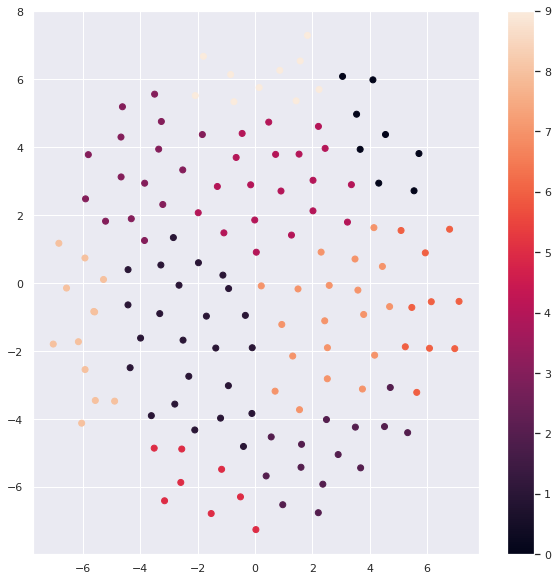

In [40]:
# Encoded Joke embedding representations in 2D

!pip install bhtsne

from sklearn.cluster import KMeans
from bhtsne import tsne

kmeans = KMeans(n_clusters=10, random_state=2020).fit(encoded_jokes.iloc[:,:3])
x_joke_cluster_labels = kmeans.labels_

x_joke_2_embedded = tsne(encoded_jokes.iloc[:,:3].astype('float64'))

plt.figure(figsize=(10, 10))
plt.scatter(x_joke_2_embedded[:, 0], x_joke_2_embedded[:, 1], c=x_joke_cluster_labels)
plt.colorbar()
plt.show()

Encoding text length representations using PCA

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x=StandardScaler().fit_transform(np.array(jokes.iloc[:,2:6]))
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['textlen1', 'textlen2','textlen3'])
principalDf['joke_id']=jokes['joke_id'].values
pca.explained_variance_ratio_

array([0.66368982, 0.24927131, 0.08647941])

In [42]:
jokedf=encoded_jokes.merge(principalDf,on='joke_id',how='inner')
jokedf.to_csv('./jokedf.csv',header=True,index=False)
del jokes
jokedf.head()

,e1,e2,e3,joke_id,textlen1,textlen2,textlen3
0,0.838009,0.042671,0.014928,1,-1.213553,-0.674291,0.686517
1,1.767683,0.892423,0.024181,2,-1.628140,-1.222391,-0.033288
2,0.622681,0.205332,0.019518,3,-1.424102,-0.668834,0.333237
3,0.600861,1.113976,0.009566,4,-1.657811,1.710545,0.281985
4,1.151586,-0.379801,0.002598,5,-1.717459,-0.903227,-0.213810


In [131]:
import random
random.seed(2020)
users=list(set(train['user_id']))
val_users=random.sample(users,int(len(users)*.1))
train_users=[u for u in users if u not in val_users]
print(len(train_users),len(val_users))

36777 4086


In [132]:
# Splitting train into train and val sets

train_vae = train.iloc[:,1:4].loc[train['user_id'].isin(train_users)]
val_vae = train.iloc[:,1:4].loc[train['user_id'].isin(val_users)]

print(train_vae.shape,val_vae.shape)

(984547, 3) (107512, 3)


In [133]:
# Recommender system for eliciting user vecs

from scipy import sparse

def create_sparse_matrix(data):
  user_ids=np.array(data['user_id'])
  joke_ids=np.array(data['joke_id'])
  ratings=np.array(data['Rating'])+np.repeat(11,(len(data),)) # Changing ratings from -10 to 10 scale to 1 to 21
  user2id = dict((uid, i) for (i, uid) in enumerate(list(set(user_ids))))
  joke2id = dict((jid, i) for (i, jid) in enumerate(list(set(joke_ids))))
  #ratings=[-100 if r==0 else r for r in ratings] # Replace 0 ratings with -100
  rows=[user2id[u] for u in user_ids]
  cols=[joke2id[j] for j in joke_ids]
  smat=sparse.csr_matrix((ratings,(rows,cols)),shape=(len(set(user_ids)),len(set(joke_ids))),dtype='float64')

  #mmat=smat.toarray()
  #mmat=np.where(mmat==0,-10.1,mmat) # All missing ratings are imputed with -10.1
  #mmat=np.where(mmat==-100,0,mmat) # All 0 ratings are restored
  #smat=sparse.csr_matrix(mmat)
  return smat


In [134]:
train_mat=create_sparse_matrix(train_vae)
val_mat=create_sparse_matrix(val_vae)
train_val_mat_total=sparse.csr_matrix(np.append(train_mat.toarray(),val_mat.toarray(),axis=0))

In [88]:
del train_vae,val_vae

In [89]:
print(train_mat.shape,val_mat.shape)


(36777, 139) (4086, 139)


In [90]:
l=[]
f=[]
for i in range(150,500):
  l.append(36777%i)
  f.append(i)

sorted_pairs=sorted(zip(f,l),key=lambda x: x[1])

In [91]:
list(sorted_pairs)[:5]

[(299, 0), (162, 3), (227, 3), (454, 3), (317, 5)]

In [92]:
4086%454

0

In [93]:
train_mat=train_mat[:36777-3]
val_mat=val_mat[:4086-0]
train_val_mat=sparse.csr_matrix(np.append(train_mat.toarray(),val_mat.toarray(),axis=0))

In [94]:
pickle.dump(train_mat, open("./train_mat.file", "wb"))
pickle.dump(val_mat,open('./val_mat.file','wb'))
pickle.dump(train_val_mat,open('./train_val_mat.file','wb'))
pickle.dump(train_val_mat_total,open('./train_val_mat_total.file','wb'))

In [55]:
with open('./train_mat.file','rb') as f:
  train_mat=pickle.load(f)

with open('./val_mat.file','rb') as f:
  val_mat=pickle.load(f)  

with open('./train_val_mat.file','rb') as f:
  train_val_mat=pickle.load(f) 

with open('./train_val_mat_total.file','rb') as f:
  train_val_mat_total=pickle.load(f) 

jokedf=pd.read_csv('./jokedf.csv')  

Training Hybrid VAE for ratings prediction using user, joke ids, ratings and joke text information

In [143]:
from keras.layers import Input, Dense, Lambda, multiply, Embedding, Flatten, LSTM
import tensorflow as tf
import os
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from IPython.display import clear_output

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [144]:
# encoder/decoder network size
batch_size=454
original_dim=139 # number of jokes
intermediate_dim1=90
intermediate_dim2=40
intermediate_dim3=90
intermediate_dim4=200

latent_dim=6
nb_epochs=20
epsilon_std=1.0

vocab_size = 139
embed_dim = 6
seq_length = 139

embedding_matrix = np.append(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) ,np.array(jokedf.drop('joke_id',axis=1)), axis =0)

# encoder network
x=Input(batch_shape=(batch_size,original_dim))
embedding_layer = Embedding(vocab_size+1, embed_dim, weights=[embedding_matrix], input_length=seq_length, trainable=True)
embed = embedding_layer(x)
flat_embed = Flatten()
embed = flat_embed(embed)
h1=Dense(intermediate_dim1, activation='relu')(embed)
h2=Dense(intermediate_dim2, activation='relu')(h1)
h3=Dense(intermediate_dim3, activation='relu')(h2)
h4=Dense(intermediate_dim4, activation='tanh')(h3)

z_mean=Dense(latent_dim)(h4)
z_log_var=Dense(latent_dim)(h4)

In [145]:
# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [146]:
# decoder network
h_decoder1=Dense(intermediate_dim1, activation='relu')
h_decoder2=Dense(intermediate_dim2, activation='relu')
h_decoder3=Dense(intermediate_dim3, activation='relu')
h_decoder4=Dense(intermediate_dim4, activation='tanh')

x_bar=Dense(original_dim, activation='linear')
h_decoded1 = h_decoder1(z)
h_decoded2 = h_decoder2(h_decoded1)
h_decoded3 = h_decoder3(h_decoded2)
h_decoded4 = h_decoder4(h_decoded3)

x_decoded = x_bar(h_decoded4)

vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    mask = tf.greater_equal(x, 1) # Masking values corresponding to missing items for each user
    reconst_loss=tf.reduce_mean(tf.boolean_mask(tf.pow(x_decoded - x,2), mask))
    #reconst_loss=original_dim*objectives.mse(x,x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

In [147]:
vae.compile(optimizer='adam', loss=vae_loss)
print(vae.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (454, 139)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (454, 139, 6)        840         input_9[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (454, 834)           0           embedding_5[0][0]                
__________________________________________________________________________________________________
dense_86 (Dense)                (454, 90)            75150       flatten_5[0][0]                  
___________________________________________________________________________________________

In [82]:
x_train = train_mat
print("number of training users: ", x_train.shape[0])
x_val = val_mat

number of training users:  36774


In [83]:
x_train=train_val_mat
print("number of training users: ", x_train.shape[0])

number of training users:  40860


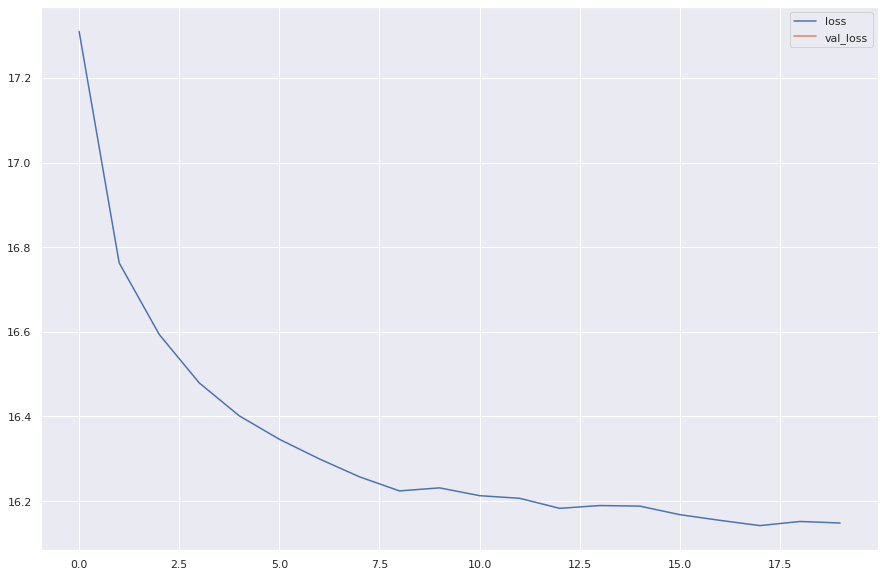

In [84]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = np.array(x[index_batch,:].todense()).astype(float)
        #joke_indices = np.array([np.ones((139,))])
        #joke_indices = np.repeat(joke_indices, batch_size, axis = 0)

        #joke_indices=np.where(x_batch==0,0,joke_indices)
        #x_new_batch = x_batch*joke_indices
        
        counter += 1
        #yield (x_new_batch, x_batch)
        yield (x_batch, x_batch)
        if (counter >= number_of_batches):
            counter=0

weightsPath = "weights.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)

#vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 36774) , samples_per_epoch=36774, nb_epoch=nb_epochs,
#                  validation_data = (x_val,x_val), callbacks = [checkpointer,plot_losses])

vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 36774+4086) , samples_per_epoch=36774+4086, nb_epoch=nb_epochs,
                   callbacks = [checkpointer,reduce_lr,plot_losses])

In [148]:
weightsPath = "./weights.hdf5"
vae.load_weights(weightsPath)

In [95]:
train_val_mat_total.shape[0]%454

3

In [98]:
encoder = Model(x, z_mean)
train_encoded1 = encoder.predict(train_val_mat_total[:-3].toarray(), batch_size=batch_size)
train_encoded2 = encoder.predict(train_val_mat_total[3:].toarray(), batch_size=batch_size) 
train_encoded = np.append(train_encoded1,train_encoded2[-3:],axis=0)
print(train_encoded.shape)

(40863, 6)


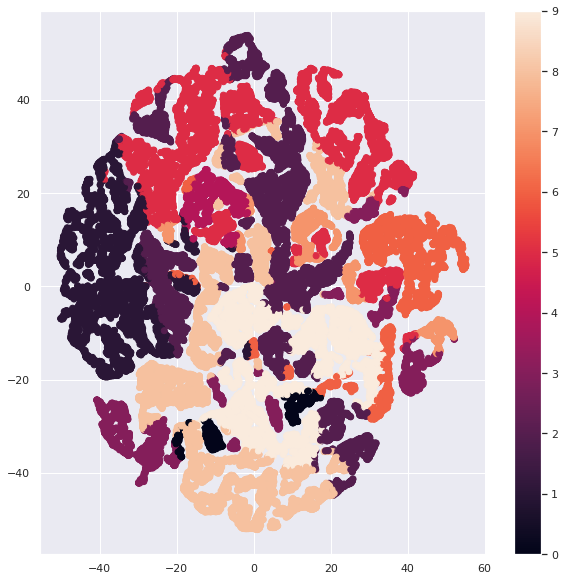

In [102]:
# Visualizing user embeddings

from sklearn.cluster import KMeans
from bhtsne import tsne

kmeans = KMeans(n_clusters=10, random_state=0).fit(train_encoded)
x_train_cluster_labels = kmeans.labels_

x_train_2_embedded = tsne(train_encoded.astype('float64'))

plt.figure(figsize=(10, 10))
plt.scatter(x_train_2_embedded[:, 0], x_train_2_embedded[:, 1], c=x_train_cluster_labels)
plt.colorbar()
plt.show()

Making predictions for test set using trained VAE

In [149]:
test_users=test.user_id.unique()
users=pd.Series(list(train_users)+list(val_users))

0        True
1        True
2        True
3        True
4        True
         ... 
40858    True
40859    True
40860    True
40861    True
40862    True
Length: 40863, dtype: bool

In [156]:
offset=test_to_go.shape[0]%batch_size

In [157]:
test_to_go=train_val_mat_total.toarray()[users.isin(test_users)]
test_ratings1=vae.predict(test_to_go[:-offset],batch_size=batch_size)
test_ratings2=vae.predict(test_to_go[offset:],batch_size=batch_size)
test_ratings=np.append(test_ratings1,test_ratings2[-offset:],axis=0)

In [164]:
preds=[]
for num,row in test.iterrows():
  preds.append(test_ratings[np.where(users==row.user_id)[0][0],row.joke_id-1]-11)

test['Rating']=preds
submission_vae=test[['id','Rating']]
submission_vae.to_csv('submission_vae.csv',header=True,index=False)

Creating a new dataframe with user and text embeddings for train data

In [105]:
userdf=pd.DataFrame(train_encoded,columns=['user_emb'+str(i) for i in range(train_encoded.shape[1])])
userdf['user_id']=list(train_users)+list(val_users)

In [108]:
new_train=train[['user_id','joke_id','Rating']].merge(userdf,on='user_id',how='inner').merge(jokedf,on='joke_id',how='inner')
new_train.head()
new_train.to_csv('new_train.csv',header=True,index=False)

In [109]:
new_train.head()

,user_id,joke_id,Rating,user_emb0,user_emb1,user_emb2,user_emb3,user_emb4,user_emb5,e1,e2,e3,textlen1,textlen2,textlen3
0,31030,110,2.750,0.001139,-0.021546,0.291849,0.000602,0.008752,0.012992,-0.472758,1.005235,0.004496,1.985948,-1.280161,1.085622
1,40642,110,9.031,0.013182,-0.213708,0.337395,0.004880,0.005848,0.019863,-0.472758,1.005235,0.004496,1.985948,-1.280161,1.085622
2,25664,110,5.312,0.013796,0.231084,0.632777,-0.006620,0.021194,0.021596,-0.472758,1.005235,0.004496,1.985948,-1.280161,1.085622
3,8445,110,-2.875,0.024057,-1.444011,-0.153543,-0.007267,0.008200,-0.006096,-0.472758,1.005235,0.004496,1.985948,-1.280161,1.085622
4,28794,110,0.938,0.006204,0.280620,0.512503,-0.009217,0.013466,0.018845,-0.472758,1.005235,0.004496,1.985948,-1.280161,1.085622


Testing out xgboost on created dataset

In [114]:
import xgboost
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error

In [118]:
train_x,val_x,train_y,val_y=train_test_split(new_train.drop(['user_id','joke_id','Rating'],axis=1),new_train['Rating'],test_size=0.2)

In [119]:
print(train_x.shape,train_y.shape,val_x.shape,val_y.shape)

(873647, 12) (873647,) (218412, 12) (218412,)


In [120]:
#for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[10000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}
                   
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed: 102.6min
[Parallel(n_jobs=6)]: Done  1

KeyboardInterrupt: ignored

In [ ]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)